<a href="https://colab.research.google.com/github/Elllifa/CNN-classification/blob/master/CleanedVsDirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install Kaggle library
!pip install -q kaggle

from google.colab import files
uploaded = files.upload()

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
# Downlaod data for the platesv2challenge
!kaggle competitions download -c platesv2

In [0]:
import zipfile
from keras.preprocessing.image import ImageDataGenerator
from keras import applications, optimizers
from keras.layers import  Dense, Conv2D, Flatten, Activation, Dropout
from keras.models import Sequential, Model
import pandas as pd
from pandas import DataFrame
import numpy as np
import cv2
from matplotlib import pyplot as plt


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [0]:
img_size = 224
batch_size = 8
epochs = 20
train_steps_per_epoch = 20

In [0]:
fantasy_zip = zipfile.ZipFile('../content/plates.zip')
fantasy_zip.extractall('../content/')

In [0]:
def my_preprocessing_func(img):
    image = np.array(img)
    return image / 255

In [0]:
def delete_background(img):
  mask = np.zeros(img.shape[:2],np.uint8)

  #dst = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #plt.imshow(dst)
  img = img.astype('uint8')
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)

  rect = (round(0.05*img.shape[1]),round(0.05*img.shape[0]),round(0.9*img.shape[1]),round(0.9*img.shape[0]))  #rect = (start_x, start_y, width, height)

  cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
  img = img*mask2[:,:,np.newaxis]
  
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img/255

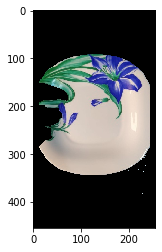

In [0]:
img = cv2.imread('../content/plates/train/cleaned/0007.jpg')
img = delete_background(img)
plt.imshow(img)

In [0]:
train_datagen=ImageDataGenerator(

        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,

        vertical_flip = True,
        preprocessing_function=delete_background,
        #preprocessing_function=my_preprocessing_func
        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        '../content/plates/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle = True,
        class_mode='binary',
        subset="training")

val_generator = train_datagen.flow_from_directory(
        '../content/plates/train',
        target_size=(img_size, img_size),
        shuffle=True,
        batch_size=1,
        class_mode='binary',
        subset="validation")

test_datagen = ImageDataGenerator(preprocessing_function=delete_background)
test_generator = test_datagen.flow_from_directory(  
        '../content/plates',
        classes=['test'],
        target_size = (img_size, img_size),
        batch_size = 1,
        shuffle = False,        
        class_mode = 'binary')

Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 744 images belonging to 1 classes.


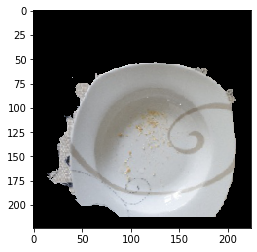

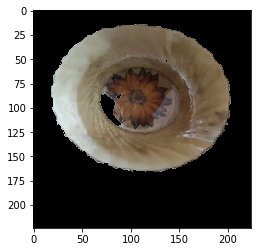

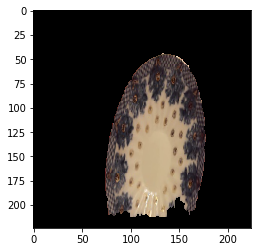

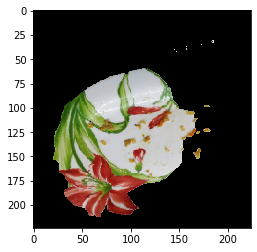

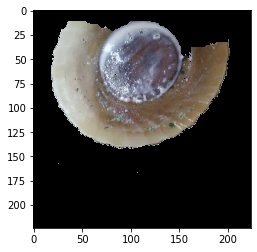

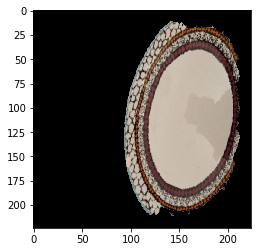

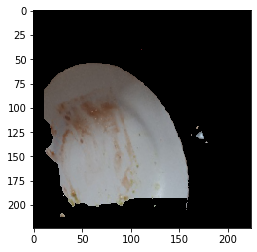

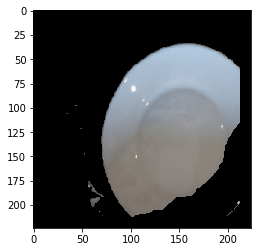

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x_batch, y = next(train_generator)
for i in range(8):
    image = x_batch[i]
    plt.imshow(image)
    #print("shape of image: {}".format(image.dtype))
    plt.show()
#plt.imshow(x_batch[0].astype(np.uint8))

In [0]:
base_model = applications.InceptionResNetV2(weights='imagenet', 
                          include_top=False, 
                          input_shape=(img_size, img_size, 3))
base_model.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(loss='binary_crossentropy', optimizer = optimizers.rmsprop(lr=0.0001, decay=1e-5), metrics=['accuracy'])

In [0]:
model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=8,
        verbose=1)

In [0]:
test_generator.reset()
predict = model.predict_generator(test_generator, steps = len(test_generator.filenames))
d = {'id': [n for n in range(len(predict))], 
     'label': ['dirty' if x > 0.5 else 'cleaned' for x in predict]}
result_df = DataFrame(data=d)
print(result_df['label'].value_counts())
result_df.to_csv('Br_kaggle_sub.csv', index=False)

In [0]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


# create a link to download the dataframe
create_download_link(result_df)